In [46]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import shutil

In [47]:
import skvideo
import skvideo.io

In [48]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [49]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    #skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8))

In [50]:
def plot_video(videodata):
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,videodata.shape[0]-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(videodata[int(i),:,:,0:3])
    plt.show()

In [51]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [52]:
def safe_mkdir_subdirs(fn):
    fn_split = fn.split('/')
    n = len(fn.split('/'))
    paths = ['/'.join(fn_split[0:i]) for i in range(0,n) if len('/'.join(fn_split[0:i]))>1]
    for path in paths:
        safe_mkdir(path)

In [53]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [54]:
def bg_inpaint(bg,mask,inpaint_radius=3,inpainting=cv2.INPAINT_TELEA):
    #cv2.INPAINT_TELEA or cv2.INPAINT_NS)
    #bg_inpainted = cv2.inpaint((bg[:,:,0:3]*255).astype(np.uint8),mask,inpaint_radius,inpainting)
    bg_inpainted = cv2.inpaint((bg[:,:,0:3]).astype(np.uint8),mask,inpaint_radius,inpainting)
    return bg_inpainted

In [55]:
masks = np.load('./Data/data_good_videos_1p_masks.npz')['arr']
fns = np.load('./Data/data_good_videos_1p_fns.npz')['arr']
paddings = np.load('./Data/data_good_videos_1p_paddings.npz')['arr']

In [56]:
masks.shape

(4060, 360, 640)

In [57]:
%%time
filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
masks_to_inpaint = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']

CPU times: user 18 s, sys: 826 ms, total: 18.9 s
Wall time: 19.3 s


In [58]:
masks_to_inpaint.shape

(4060, 360, 640)

In [59]:
filled_spots.mean()

0.5433497536945813

In [60]:
filled_spots.sum()

2206

In [61]:
(spots_found_for * filled_spots).sum()

1521

In [62]:
good_idxs = np.nonzero((spots_found_for * filled_spots))[0]
good_idxs

array([   1,    3,    4, ..., 4046, 4057, 4059])

65
104


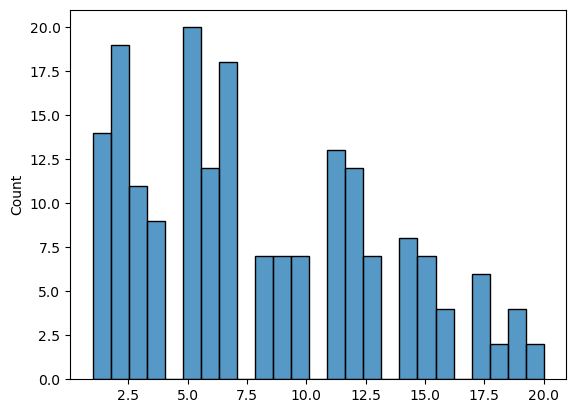

In [63]:
all_cats = np.array([fns[good_idxs][i].split('/')[-2] for i in range(good_idxs.shape[0])]);
u,c = np.unique(all_cats,return_counts=True);
sns.histplot(c,bins=25);

print((c>10).sum())
print((c>6).sum())

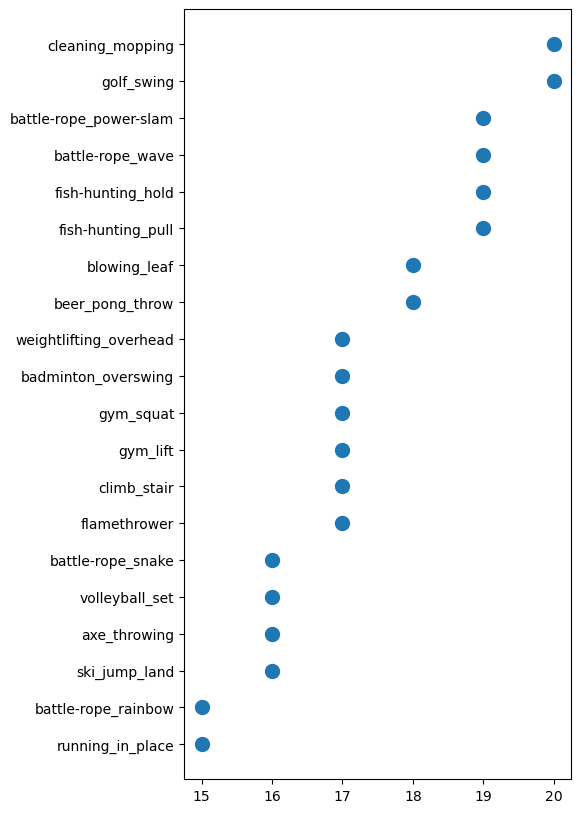

In [64]:
I = np.argsort(c)[::-1]
plt.figure(figsize=(5,10))
n = 20
xs = np.arange(n)
plt.plot(c[I][0:n][::-1],xs,'.',markersize=20)
plt.yticks(np.arange(n),labels=u[I][0:n][::-1],rotation=0);

In [65]:
len(good_idxs)

1521

In [66]:
i = 4

In [67]:
which = good_idxs[i]
where = int(where_to_inpaint_idx[which])
print((which,where))

(6, 3367)


In [69]:
video_data_where_fn = fns[where].replace('_item_0_masks.npy','.mp4')
video_data_where_seg_fn = fns[where].replace('_item_0_masks.npy','_item_0_fwd_seg.mp4')

print(video_data_where_fn)
print(video_data_where_seg_fn)

/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4/taking_selfie/taking_selfie_007.mp4
/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4/taking_selfie/taking_selfie_007_item_0_fwd_seg.mp4


In [70]:
video_data_where = load_video(video_data_where_fn)
video_data_where_seg = load_video(video_data_where_seg_fn)

In [71]:

video_data_where_inp = np.array([bg_inpaint(video_data_where[frame,:,:,:],mask=(masks_to_inpaint[which]*255).astype(np.uint8),inpaint_radius=3,inpainting=cv2.INPAINT_TELEA) for frame in range(video_data_where.shape[0])])



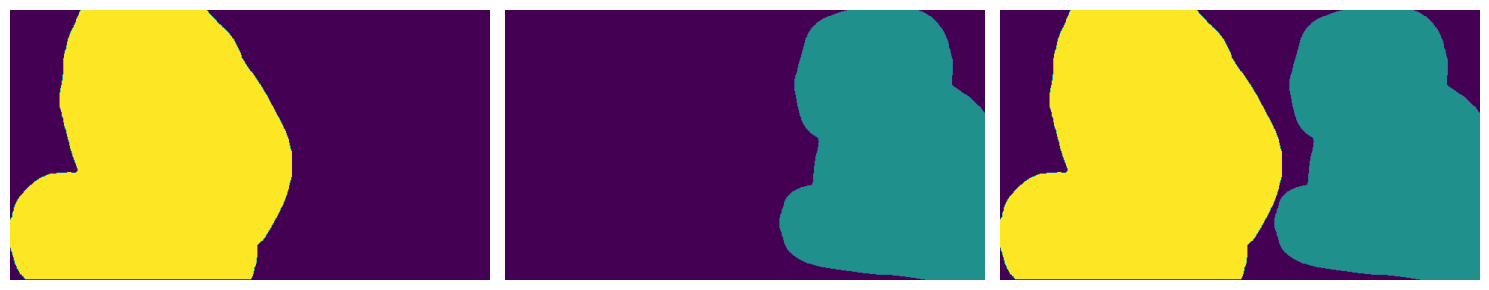

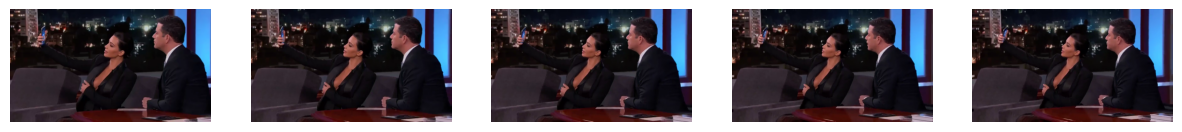

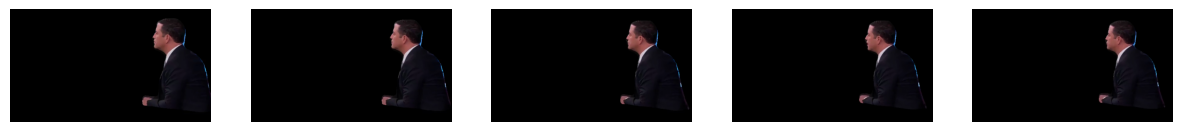

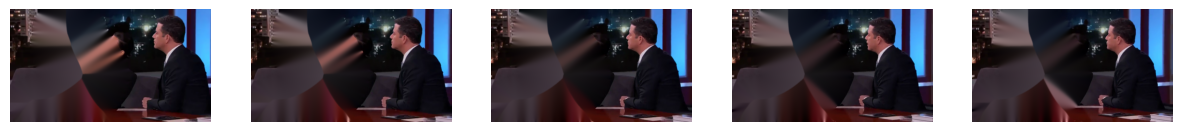

<Figure size 640x480 with 0 Axes>

In [84]:
plot_triple(masks_to_inpaint[which],masks[where,:,:]+paddings[where,:,:])
plot_video(video_data_where)
plot_video(video_data_where_seg)
plot_video(video_data_where_inp)

plt.savefig('temp.png')

In [73]:
category = fns[where].split('/')[-2]
category

'taking_selfie'

In [74]:
dataset_name = 'dataset-v1'
safe_mkdir(os.path.join('./Data',dataset_name))

In [75]:
out_folder = os.path.join('./Data',dataset_name,category)
safe_mkdir(out_folder)

In [76]:
shutil.copyfile(src=video_data_where_fn, 
                dst=os.path.join(out_folder,video_data_where_fn.split('/')[-1]))

'./Data/dataset-v1/taking_selfie/taking_selfie_007.mp4'

In [77]:
shutil.copyfile(src=video_data_where_seg_fn, 
                dst=os.path.join(out_folder,video_data_where_seg_fn.split('/')[-1]))

'./Data/dataset-v1/taking_selfie/taking_selfie_007_item_0_fwd_seg.mp4'

In [78]:
## COPY OVER BG ONLY

In [79]:
save_video(video_data_where_inp,os.path.join(out_folder,video_data_where_seg_fn.split('/')[-1]).replace('_fwd_seg.mp4','_bg_inp.mp4'))

'CPR/CPR_000_item_0_masks.npy'

In [33]:
chech_done = np.array([os.path.exists(os.path.join(  './Data',dataset_name,'/'.join(fns[i].split('/')[-2::]).replace('_item_0_masks.npy','.mp4')  )) for i in good_idxs])

In [35]:
chech_done.mean()

0.6443129520052597

In [43]:
good_idxs[3]

5

In [45]:
fns[good_idxs[5]]

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4/CPR/CPR_008_item_0_masks.npy'

In [42]:
(np.argwhere(~chech_done)[0][0])

3